In [2]:
!pip install torchinfo

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchinfo
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
# Аугментация и нормализация
transform = transforms.Compose([
transforms.RandomPerspective(),
transforms.RandomCrop(32, padding=4),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Загрузкаданных
trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)


100%|██████████| 182M/182M [00:01<00:00, 95.8MB/s]


100%|██████████| 64.3M/64.3M [00:01<00:00, 32.7MB/s]


In [6]:
def tensor_info(tensor):
    print(f'Размер тензора: {tensor.shape}')
    print(f'Тип данных элементов тензора: {tensor.dtype}')
    print(f'Максимальный элемент: {tensor.max()}')
    print(f'Минимальный элемент: {tensor.min()}')
    print(f'Тип данных тензора: {type(tensor)}')

In [7]:
tensor_info(trainset[0][0])

Размер тензора: torch.Size([3, 32, 32])
Тип данных элементов тензора: torch.float32
Максимальный элемент: -0.1294117569923401
Минимальный элемент: -1.0
Тип данных тензора: <class 'torch.Tensor'>


In [8]:
set(trainset.labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [9]:
len(trainset), trainset[0][0].shape

(73257, torch.Size([3, 32, 32]))

In [10]:
len(testset), testset[0][0].shape

(26032, torch.Size([3, 32, 32]))

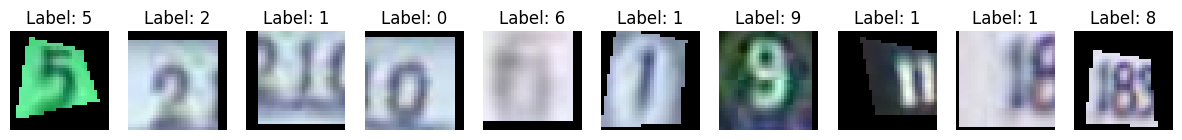

In [11]:
# Функция для отображения изображений
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        image, label = dataset[i]  # Получаем изображение и метку
        axes[i].imshow((image.permute(1, 2, 0) - image.min())/ (image.max() - image.min()) )  # Преобразуем для отображения
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Отображаем 10 изображений из тренировочного датасета
show_images(testset, num_images=10)

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=3, stride=1, padding=1)
        # self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(12 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = x.view(-1, 12 * 8 * 8)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        # x = self.dropout(x)
        x = self.fc4(x)
        return x

In [21]:
# Оценка точности модели
def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    # print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Обучение модели
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu'):

    model = model.to(device)
    model.train()

    loss_history = []
    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):

        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Обнуляем градиенты

            outputs = model(images)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисляем потерю

            loss.backward()  # Обратный проход
            optimizer.step()  # Обновляем параметры

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        train_acc = correct / total * 100
        train_accs.append(train_acc)

        test_acc = evaluate_model(model, test_loader, device=device)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

    return loss_history, train_accs, test_accs

In [32]:
model = SimpleCNN()
torchinfo.summary(model, input_size=(3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [6, 32, 32]               168
├─ReLU: 1-2                              [6, 32, 32]               --
├─AvgPool2d: 1-3                         [6, 16, 16]               --
├─Conv2d: 1-4                            [9, 16, 16]               495
├─ReLU: 1-5                              [9, 16, 16]               --
├─AvgPool2d: 1-6                         [9, 8, 8]                 --
├─Conv2d: 1-7                            [12, 8, 8]                984
├─ReLU: 1-8                              [12, 8, 8]                --
├─Linear: 1-9                            [1, 512]                  393,728
├─ReLU: 1-10                             [1, 512]                  --
├─Linear: 1-11                           [1, 256]                  131,328
├─ReLU: 1-12                             [1, 256]                  --
├─

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(device)
num_epochs = 10
device

device(type='cuda')

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [38]:
loss_history, train_accs, test_accs = train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=num_epochs, device=device)
# accuracy = evaluate_model(model, test_loader, device=device)

Epoch [1/10], Loss: 2.2078, Train Accuracy: 19.93%, Test Accuracy: 27.39%
Epoch [2/10], Loss: 1.7250, Train Accuracy: 39.49%, Test Accuracy: 52.45%
Epoch [3/10], Loss: 1.3225, Train Accuracy: 54.59%, Test Accuracy: 59.22%
Epoch [4/10], Loss: 1.1664, Train Accuracy: 60.75%, Test Accuracy: 63.64%
Epoch [5/10], Loss: 1.0825, Train Accuracy: 63.81%, Test Accuracy: 64.90%
Epoch [6/10], Loss: 1.0304, Train Accuracy: 65.90%, Test Accuracy: 67.37%
Epoch [7/10], Loss: 0.9975, Train Accuracy: 66.87%, Test Accuracy: 68.95%
Epoch [8/10], Loss: 0.9790, Train Accuracy: 67.72%, Test Accuracy: 69.22%
Epoch [9/10], Loss: 0.9584, Train Accuracy: 68.52%, Test Accuracy: 70.29%
Epoch [10/10], Loss: 0.9330, Train Accuracy: 69.38%, Test Accuracy: 68.67%


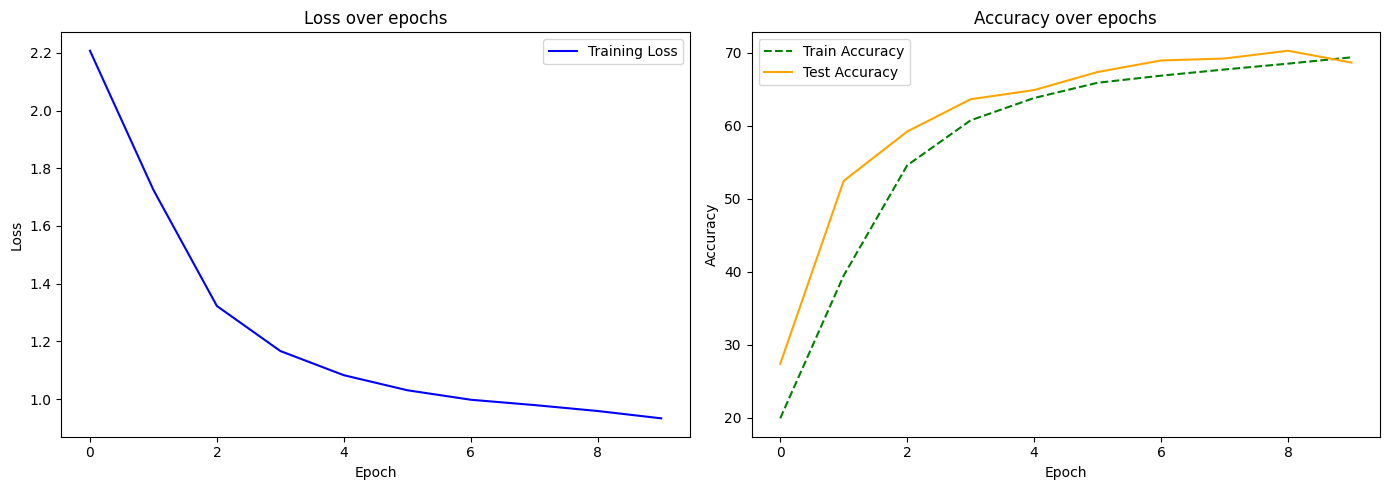

In [39]:
# Количество эпох (длина списков)
epochs = len(loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accs, label='Train Accuracy', color='green', linestyle='--')
plt.plot(range(epochs), test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()

With modification

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(device)
num_epochs = 10
device

device(type='cuda')

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01, weight_decay=1e-6)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0001)

In [63]:
loss_history, train_accs, test_accs = train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=num_epochs, device=device)
# accuracy = evaluate_model(model, test_loader, device=device)

Epoch [1/10], Loss: 37.2192, Train Accuracy: 18.76%, Test Accuracy: 19.59%
Epoch [2/10], Loss: 2.2103, Train Accuracy: 19.08%, Test Accuracy: 20.77%
Epoch [3/10], Loss: 2.0873, Train Accuracy: 25.46%, Test Accuracy: 32.15%
Epoch [4/10], Loss: 1.7554, Train Accuracy: 37.86%, Test Accuracy: 42.39%
Epoch [5/10], Loss: 1.5420, Train Accuracy: 46.71%, Test Accuracy: 45.74%
Epoch [6/10], Loss: 1.4081, Train Accuracy: 52.27%, Test Accuracy: 52.70%
Epoch [7/10], Loss: 1.3201, Train Accuracy: 55.95%, Test Accuracy: 54.92%
Epoch [8/10], Loss: 1.2387, Train Accuracy: 59.04%, Test Accuracy: 50.79%
Epoch [9/10], Loss: 1.1780, Train Accuracy: 61.50%, Test Accuracy: 49.54%
Epoch [10/10], Loss: 1.1294, Train Accuracy: 63.27%, Test Accuracy: 59.40%


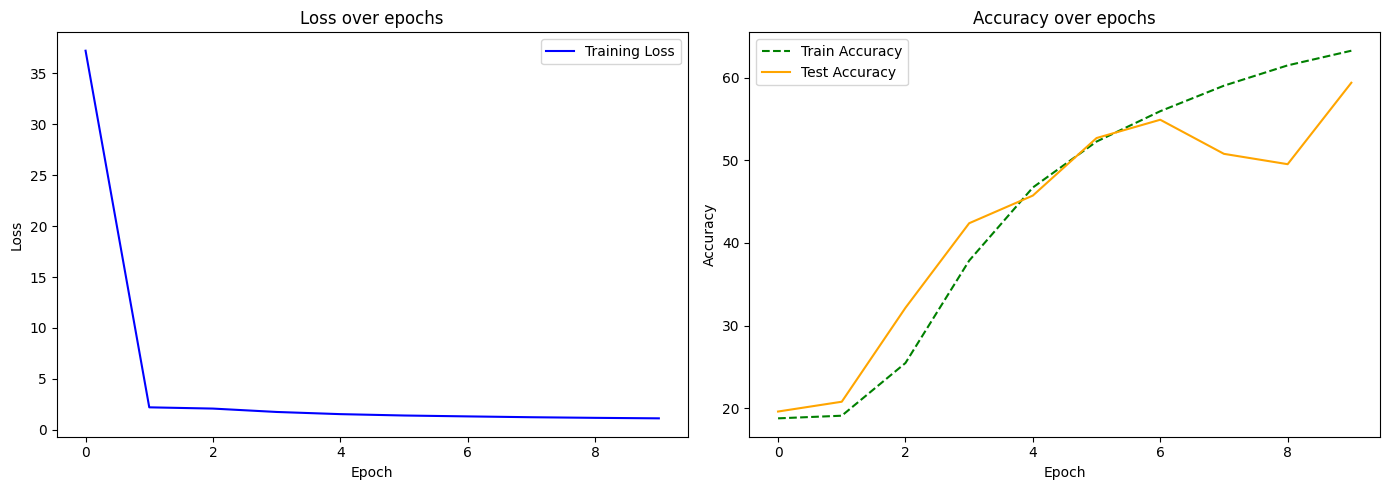

In [64]:
# Количество эпох (длина списков)
epochs = len(loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accs, label='Train Accuracy', color='green', linestyle='--')
plt.plot(range(epochs), test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()